<a href="https://colab.research.google.com/github/madhukarayush/Covid-19-Prediction-Using-Apache-Spark/blob/main/Covid-19-Prediction-Using-Apache-Spark/covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 51.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ac6e8fb80ccac10d38438ecffe6c0144792085451e23f8803905cc9eca3260dd
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
file = 'owid-covid-data.csv'

In [ ]:
import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Covid Data Mining").config('spark.sql.debug.maxToStringFields', 2000).getOrCreate()
full_df = spark.read.csv(file, header=True, inferSchema=True)

In [ ]:
print(f"The total number of samples is {full_df.count()}, with each sample corresponding to {len(full_df.columns)} features.")

The total number of samples is 33361, with each sample corresponding to 67 features.


In [ ]:
full_df.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

In [ ]:
full_df.select("iso_code","location","continent","date","tests_units").show(5)

+--------+-----------+---------+----------+-----------+
|iso_code|   location|continent|      date|tests_units|
+--------+-----------+---------+----------+-----------+
|     AFG|Afghanistan|     Asia|2020-02-24|       null|
|     AFG|Afghanistan|     Asia|2020-02-25|       null|
|     AFG|Afghanistan|     Asia|2020-02-26|       null|
|     AFG|Afghanistan|     Asia|2020-02-27|       null|
|     AFG|Afghanistan|     Asia|2020-02-28|       null|
+--------+-----------+---------+----------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F

miss_vals = full_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

import pandas as pd

pd.DataFrame.from_records([miss_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_boosters,total_boosters_per_hundred,...,new_cases_smoothed,new_cases_smoothed_per_million,new_cases,new_cases_per_million,total_cases,total_cases_per_million,iso_code,location,date,population
0,32646,32646,32477,32477,32477,32477,31902,31902,30237,30237,...,468,468,132,132,103,103,0,0,0,0


In [ ]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))

In [ ]:
dates = ("2021-01-01", "2021-02-28")
df = full_df.where(F.col('date').between(*dates))

In [ ]:
print(f"The total number of samples is {df.count()}, with each sample corresponding to {len(df.columns)} features.")

miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([miss_vals])

The total number of samples is 2596, with each sample corresponding to 67 features.


,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,population
0,2537,2537,2524,2524,2524,2524,2514,2514,2478,2478,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.sort("continent").select("iso_code","continent","location").show(5)

+--------+---------+--------+
|iso_code|continent|location|
+--------+---------+--------+
|OWID_AFR|     null|  Africa|
|OWID_AFR|     null|  Africa|
|OWID_AFR|     null|  Africa|
|OWID_AFR|     null|  Africa|
|OWID_AFR|     null|  Africa|
+--------+---------+--------+
only showing top 5 rows



In [ ]:
df = df.fillna({'continent':'OWID'})

In [ ]:
df.select("tests_units").distinct().show()

+---------------+
|    tests_units|
+---------------+
|           null|
| samples tested|
|tests performed|
|  units unclear|
+---------------+



In [ ]:
df = df.fillna({'tests_units':'no info'})

In [ ]:
df = df.fillna(0)

In [ ]:
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
else:
    print("All missing values have been taken care of.")

All missing values have been taken care of.


In [ ]:
def OutlierDetector(dataframe, features, alpha=1.5):
    """
    Args:
        dataframe (pyspark.sql.dataframe.DataFrame):
            the DataFrame hosting the data
        features (string or List):
            List of features (columns) for which we wish to identify outliers.
            If set equal to 'all', outliers are identified with respect to all features.
        alpha (double):
            The parameter that defines the decision boundary (see markdown above)
    """
    feat_types = dict(dataframe.dtypes)
    if features == 'all':
        features = dataframe.columns
        
    outliers_cols = []
    
    for feat in features:
        # We only care for quantitative features
        if feat_types[feat] == 'double':
            Q1, Q3 = dataframe.approxQuantile(feat, [0.25, 0.75], 0)
            R = Q3 - Q1
            lower_bound = Q1 - (R * alpha)
            upper_bound = Q3 + (R * alpha)
            
            # In this way we construct a query, which can be matched to a DataFrame column, thus returning a new
            # column where every point that corresponds to an Outlier has a boolean value set to True
            outliers_cols.append(F.when(~F.col(feat).between(lower_bound, upper_bound), True).alias(feat + '_outlier'))
    
    # Sample points that do not correspond to outliers correspond to a False value for the new column
    outlier_df = dataframe.select(*outliers_cols)
    outlier_df = outlier_df.fillna(False)
    return outlier_df

In [ ]:
out_df = OutlierDetector(dataframe=df, features=['new_cases'], alpha=1.5)
out_df.show(5)

+-----------------+
|new_cases_outlier|
+-----------------+
|            false|
|            false|
|            false|
|            false|
|            false|
+-----------------+
only showing top 5 rows



In [ ]:
if df.count() != df.select(['location','date']).distinct().count():
    print("There are duplicate entries present in the DataFrame.")
else:
    print("Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).")

Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).


In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
othercol1 = (135/255, 121/255, 215/255)
othercol2 = (57/255, 119/255, 171/255)
othercol3 = (68/255, 81/255, 91/255)
othercol4 = (73/255, 149/255, 139/255)

In [ ]:
dates_frame = df.select("date").distinct().orderBy('date').collect()
dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

In [ ]:
df_for_mort = df.filter(F.col('population') != 0.0).withColumn("mortality", F.col("total_deaths")/F.col("population"))

for i, this_day in enumerate(dates_list):
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest mortality rate were:
▶ Belgium, with mortality rate 0.17%.
▶ Bosnia and Herzegovina, with mortality rate 0.13%.
▶ Bulgaria, with mortality rate 0.11%.
▶ Andorra, with mortality rate 0.11%.
▶ Armenia, with mortality rate 0.10%.
▶ Argentina, with mortality rate 0.09%.
▶ Brazil, with mortality rate 0.09%.
▶ Chile, with mortality rate 0.09%.
▶ Bolivia, with mortality rate 0.08%.
▶ Austria, with mortality rate 0.07%.
During 2021-02-28, the top 10 countries with the highest mortality rate were:
▶ Belgium, with mortality rate 0.19%.
▶ Bosnia and Herzegovina, with mortality rate 0.16%.
▶ Bulgaria, with mortality rate 0.15%.
▶ Andorra, with mortality rate 0.14%.
▶ Brazil, with mortality rate 0.12%.
▶ Argentina, with mortality rate 0.11%.
▶ Armenia, with mortality rate 0.11%.
▶ Chile, with mortality rate 0.11%.
▶ Bolivia, with mortality rate 0.10%.
▶ Austria, with mortality rate 0.09%.


In [ ]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 104933.164 total cases per million.
▶ Belgium, with 55731.636 total cases per million.
▶ Armenia, with 53817.76 total cases per million.
▶ Bahrain, with 53144.921 total cases per million.
▶ Aruba, with 51392.322 total cases per million.
▶ Austria, with 40131.385 total cases per million.
▶ Brazil, with 36000.968 total cases per million.
▶ Argentina, with 35732.148 total cases per million.
▶ Bosnia and Herzegovina, with 34363.232 total cases per million.
▶ Chile, with 31883.846 total cases per million.
During 2021-02-28, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 140471.081 total cases per million.
▶ Aruba, with 73613.508 total cases per million.
▶ Bahrain, with 70007.636 total cases per million.
▶ Belgium, with 66324.695 total cases per million.
▶ Armenia, with 57968.524 total cases per million.
▶ Austria, with 50805.744 tota

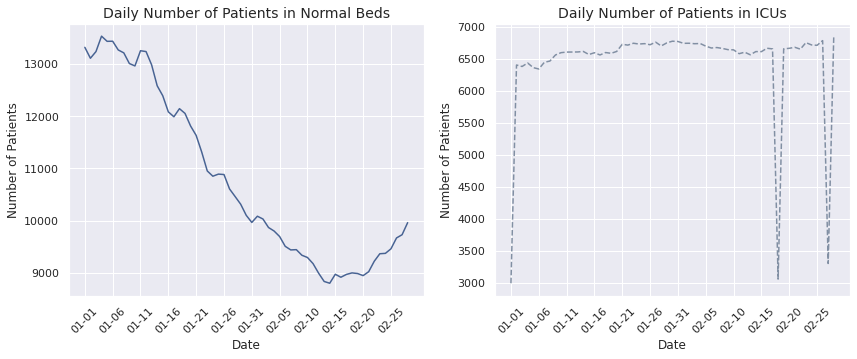

In [ ]:
dt_ord = df.orderBy("date", ascending=True).groupBy("date")

hosps = dt_ord.agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = dt_ord.agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

sns.set(style = "darkgrid")

alt_dts_list = [dt.replace('2021-', '') for dt in dates_list]
tick_marks = np.arange(len(alt_dts_list))

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for pat, col, style, ax, where in zip([hosps,icus], [mycol, mycomplcol],
                                      ['solid', 'dashed'], [ax1,ax2], ['Normal Beds','ICUs']): 
    ax.plot(alt_dts_list, pat, linestyle=style, color=col)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Patients")
    ax.set_title(f"Daily Number of Patients in {where}", fontsize=14)
    ax.set_xticks(tick_marks[::5])
    ax.set_xticklabels(alt_dts_list[::5], rotation=45)
    
plt.show()

matplotlib.rc_file_defaults()

In [ ]:
import requests, zipfile
from io import BytesIO

zip_file_url = "https://srigas.me/kaggle/owid-nb-data.zip"

request = requests.get(zip_file_url)
zipDocument = zipfile.ZipFile(BytesIO(request.content))

zipDocument.extractall()

In [ ]:
!pip install geopandas
import geopandas as gpd

shapefile = 'countries.shp'
geo_df = gpd.read_file(shapefile)[['ADMIN','ADM0_A3','geometry']]
geo_df.columns = ['location', 'iso_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['location'] == 'Antarctica'].index) # exclude Antarctica

     |████████████████████████████████| 1.0 MB 15.0 MB/s 
     |████████████████████████████████| 6.3 MB 51.2 MB/s 
     |████████████████████████████████| 16.7 MB 287 kB/s 


In [ ]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    # The conversion of the required columns into a Pandas df is necessary to perform the mapping
    day_df = df.filter(F.col('date') == this_day).select(["iso_code","total_cases"]).toPandas()

    merged_df = pd.merge(left=geo_df, right=day_df, how='left', left_on='iso_code', right_on='iso_code')

    title = f'Total COVID-19 Cases as of {this_day}'
    col = 'total_cases'
    vmin, vmax = merged_df[col].min(), merged_df[col].max()
    cmap = mycmap
    divnorm = TwoSlopeNorm(vcenter=0.08*20365726)

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))

    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=divnorm, cmap=cmap)

    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    # Empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)
    plt.savefig(f'world_map_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.
Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.
